<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
download = drive.CreateFile({'id': '1RSwoFiYQXzwgRhR7HHlJ5TYRATyfXBai'})


In [0]:
file_list = drive.ListFile(
    {'q': "'1RSwoFiYQXzwgRhR7HHlJ5TYRATyfXBai' in parents"}).GetList()

for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = f['title']
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

title: Untitled0.ipynb, id: 1VBu-bhwXGKUz_Ew25RH6VRzZD3IzN-BF
downloading to Untitled0.ipynb
title: predefined_classes.txt, id: 1O-dBOm30GdQn2m0C_5QCqrjWZAAhpPic
downloading to predefined_classes.txt
title: all_pictures.txt, id: 1lPM9fmGp_fmwzjUK4vjG6mUytjC7cFFw
downloading to all_pictures.txt
title: LABELS.zip, id: 1KsW4XPz3Kcy8s1HfKEBqob48snm3AfiN
downloading to LABELS.zip
title: GREENPATROL_DB_V1.0.zip, id: 1IrF6nrEx7NUZ9kNFsuWZdLJgTRPHwg2F
downloading to GREENPATROL_DB_V1.0.zip


In [0]:
download_Pests = drive.CreateFile({'id': '1IrF6nrEx7NUZ9kNFsuWZdLJgTRPHwg2F'})



Downloading annotations 

In [0]:
download_Annotations = drive.CreateFile({'id': '1KsW4XPz3Kcy8s1HfKEBqob48snm3AfiN'}) 


In [0]:
download_Annotations.GetContentFile('LABELS.zip')

!unzip LABELS.zip -d '/Pests'

Archive:  LABELS.zip
replace /Pests/LABELS/1_2_2_6_1_1_20180622-102849.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-102849.xml  
replace /Pests/LABELS/1_2_2_6_1_1_20180622-102918.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-102918.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-110731.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-110804.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-110827.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-110905.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-110931.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-111004.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-111118.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-111144.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-111311.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-111334.xml  
 extracting: /Pests/LABELS/1_2_2_6_1_1_20180622-111411.xm

In [14]:
download_Pests.GetContentFile('GREENPATROL_DB_V1.0.zip')
!unzip GREENPATROL_DB_V1.0.zip -d '/Pests'

Archive:  GREENPATROL_DB_V1.0.zip
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-102849.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-102918.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110731.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110804.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110827.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110905.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110931.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-111004.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-111118.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-111144.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-111311.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-111334.jpg  
 extracting: /Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-111411.jpg  
 ext

In [0]:
import tensorflow.keras

from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

Loading Data Set 

In [17]:
!pip install mrcnn


     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54931 sha256=a4aa079599feb27c9cb24095671bea51a102ec18d73da8f30d69b09fb502c011
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


In [38]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


Defining a class for Data Set 

In [0]:
class PestDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "Pests")
		# define data locations
		images_dir = '/' + dataset_dir + '/GREENPATROL_DB_V1.0/'
		annotations_dir = '/'+ dataset_dir + '/LABELS/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip all images after 150 if we are building the train set
		#	if is_train and int(image_id) >= 150:
		#		continue
			# skip all images before 150 if we are building the test/val set
		#	if not is_train and int(image_id) < 150:
		#		continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('Pests'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']


In [0]:
# train set
train_set = PestDataset()
train_set.load_dataset('Pests', is_train=True)
train_set.prepare()
# load an image

(1544, 2064, 3)
(1544, 2064, 13)


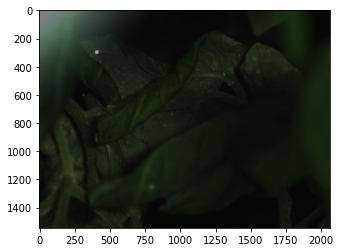

In [28]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

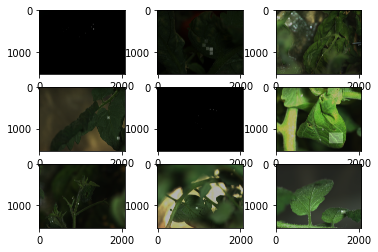

In [29]:
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [30]:
# enumerate all images in the dataset
for image_id in train_set.image_ids:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

{'id': '1_2_2_6_1_1_20180625-131314', 'source': 'dataset', 'path': '/Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180625-131314.jpg', 'annotation': '/Pests/LABELS/1_2_2_6_1_1_20180625-131314.xml'}
{'id': '1_2_2_6_1_1_20180622-134733', 'source': 'dataset', 'path': '/Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-134733.jpg', 'annotation': '/Pests/LABELS/1_2_2_6_1_1_20180622-134733.xml'}
{'id': '1_2_2_6_1_1_20180625-125443', 'source': 'dataset', 'path': '/Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180625-125443.jpg', 'annotation': '/Pests/LABELS/1_2_2_6_1_1_20180625-125443.xml'}
{'id': '1_2_2_6_1_1_20180622-142417', 'source': 'dataset', 'path': '/Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-142417.jpg', 'annotation': '/Pests/LABELS/1_2_2_6_1_1_20180622-142417.xml'}
{'id': '1_2_2_6_1_1_20180625-131151', 'source': 'dataset', 'path': '/Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180625-131151.jpg', 'annotation': '/Pests/LABELS/1_2_2_6_1_1_20180625-131151.xml'}
{'id': '1_2_2_6_1_1_20180625-130418', 's

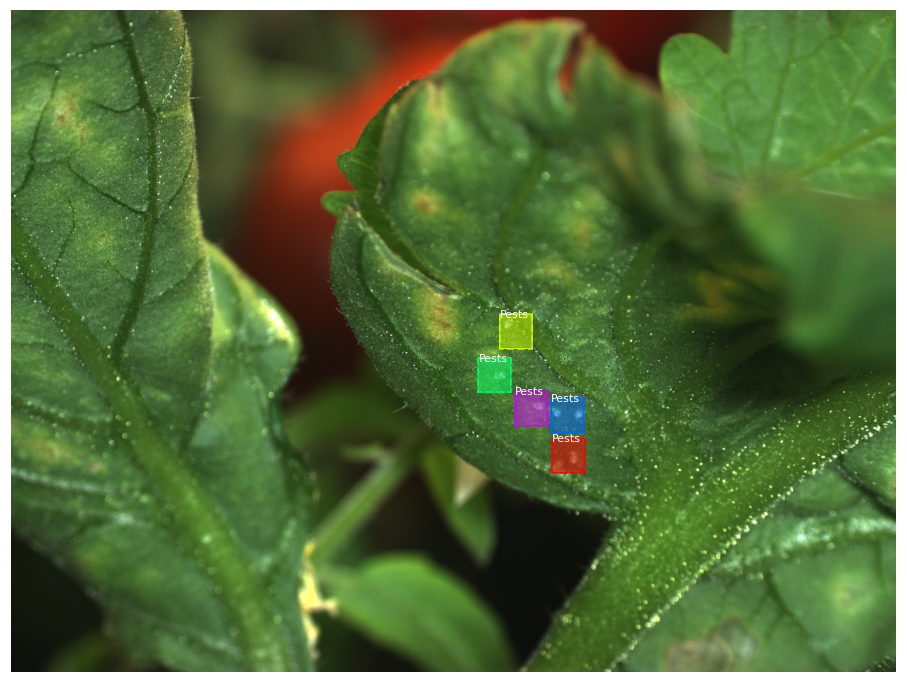

In [36]:
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [40]:
# define a configuration for the model
class PestsConfig(Config):
	# Give the configuration a recognizable name
	NAME = "Pests_cfg"
	# Number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 131

# prepare config
config = PestsConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [46]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

AttributeError: ignored